In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

import time

from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd /content/drive/My Drive/Project
!pwd

import utils

/content/drive/My Drive/Project
/content/drive/My Drive/Project


['train', 'validation']
Train Classes - ['surprised', 'disgusted']
Validation Classes - ['neutral', 'sad', 'scared', 'disgusted', 'happy', 'angry', 'surprised']
Feature batch shape: torch.Size([200, 1, 128, 128])
Labels batch shape: torch.Size([200])


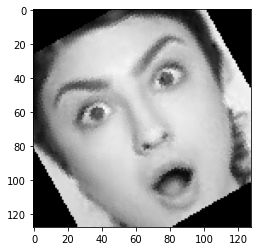

Label: 1
torch.Size([1, 128, 128])


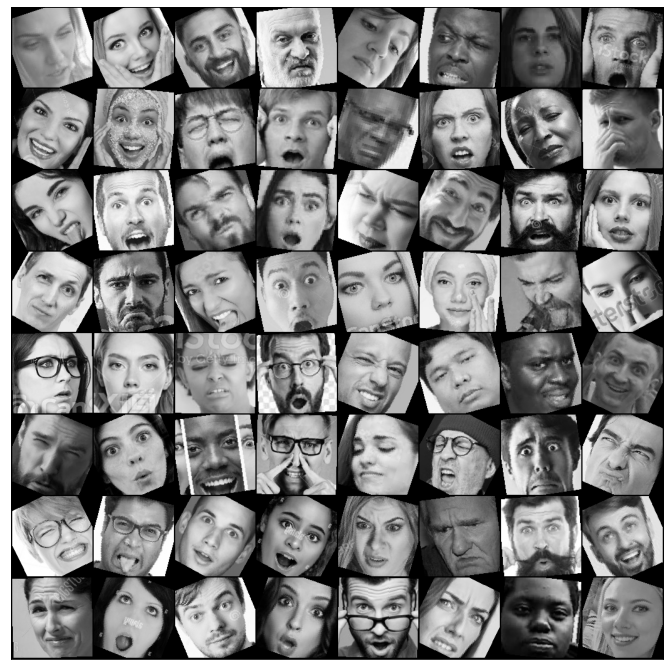

In [10]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
#                          tt.Resize((48,48)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

batch_size = 200

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [11]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dl)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.5307]) tensor([0.2889])


## LeNet5

In [12]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 64 x 64
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 64 x 64 -->    100 x 32 x 32
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 32 x 32 = 102,400 -->  100
        self.linear1 = nn.Linear(102400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 102400)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
    
        return x

### Build the net. How many parameters in total?

In [13]:
net = LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=102400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 10286407 (10.29 million) parameters in this neural network


### Do 200 passes through the training set. Divide the learning rate by 2 every 10 epochs.

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.01
device = torch.device('cuda')
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

## LeNet5 -- nn.MaxPool2d(4 x 4)

In [ ]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 32 x 32
        self.pool1  = nn.MaxPool2d(4,4)
        
        # CL2:   50 x 32 x 32  -->    100 x 32 x 32 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 32 x 32 -->    100 x 8 x 8
        self.pool2 = nn.MaxPool2d(4,4)
        
        # LL1:   100 x 32 x 32 = 6400 -->  1000 
        self.linear1 = nn.Linear(6400, 100)
        
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):
        
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 6400)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
    
        return x

### Build the net. How many parameters in total?

In [ ]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 686407 (0.69 million) parameters in this neural network


### Do 200 passes through the training set. Divide the learning rate by 2 every 10 epochs.

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.01
device = 'cpu'
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

epoch= 1 	 time= 0.6768474300702413 min 	 lr= 0.01 	 loss= 1.463407889008522 	 error= 56.07888326048851 percent
error rate on test set = 89.33333357175192 percent
 
epoch= 2 	 time= 1.5348675807317098 min 	 lr= 0.01 	 loss= 0.8080482855439186 	 error= 46.14502415060997 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 3 	 time= 2.3405340552330016 min 	 lr= 0.01 	 loss= 0.7205223739147186 	 error= 45.387741178274155 percent
error rate on test set = 85.83333293596903 percent
 
epoch= 4 	 time= 3.1316251118977863 min 	 lr= 0.01 	 loss= 0.689455009996891 	 error= 38.90594691038132 percent
error rate on test set = 88.33333253860474 percent
 
epoch= 5 	 time= 3.9102416237195334 min 	 lr= 0.01 	 loss= 0.7073360085487366 	 error= 50.92475712299347 percent
error rate on test set = 88.16666603088379 percent
 
epoch= 6 	 time= 4.676847473780314 min 	 lr= 0.01 	 loss= 0.7005644589662552 	 error= 47.0351941883564 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 7 

epoch= 46 	 time= 35.26482487916947 min 	 lr= 0.0019753086419753087 	 loss= 0.5099396891891956 	 error= 24.2141991853714 percent
error rate on test set = 87.66666650772095 percent
 
epoch= 47 	 time= 36.023573708534244 min 	 lr= 0.0019753086419753087 	 loss= 0.5047816336154938 	 error= 22.850121557712555 percent
error rate on test set = 87.1666669845581 percent
 
epoch= 48 	 time= 36.78444098234176 min 	 lr= 0.0019753086419753087 	 loss= 0.5124637559056282 	 error= 24.655339121818542 percent
error rate on test set = 87.33333349227905 percent
 
epoch= 49 	 time= 37.543913932641345 min 	 lr= 0.0019753086419753087 	 loss= 0.513026736676693 	 error= 25.210559368133545 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 50 	 time= 38.29445315202077 min 	 lr= 0.0013168724279835392 	 loss= 0.499525748193264 	 error= 22.923544049263 percent
error rate on test set = 87.33333349227905 percent
 
epoch= 51 	 time= 39.054518866539 min 	 lr= 0.0013168724279835392 	 loss= 0.5036757960

epoch= 91 	 time= 69.02682926654816 min 	 lr= 0.00026012294873748923 	 loss= 0.49274150654673576 	 error= 22.746966034173965 percent
error rate on test set = 87.8333330154419 percent
 
epoch= 92 	 time= 69.76638580560684 min 	 lr= 0.00026012294873748923 	 loss= 0.5002145543694496 	 error= 23.570995032787323 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 93 	 time= 70.5089347799619 min 	 lr= 0.00026012294873748923 	 loss= 0.49655503407120705 	 error= 23.898059129714966 percent
error rate on test set = 88.33333253860474 percent
 
epoch= 94 	 time= 71.25212657054266 min 	 lr= 0.00026012294873748923 	 loss= 0.4915398322045803 	 error= 22.54854440689087 percent
error rate on test set = 88.33333253860474 percent
 
epoch= 95 	 time= 71.98827739953995 min 	 lr= 0.00026012294873748923 	 loss= 0.4891611151397228 	 error= 22.552184760570526 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 96 	 time= 72.72786149581273 min 	 lr= 0.00026012294873748923 	 loss=

epoch= 135 	 time= 101.68068429629008 min 	 lr= 5.138231086172627e-05 	 loss= 0.49227002263069153 	 error= 23.294902592897415 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 136 	 time= 102.41878634293874 min 	 lr= 5.138231086172627e-05 	 loss= 0.48185790702700615 	 error= 22.732403129339218 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 137 	 time= 103.15773596763611 min 	 lr= 5.138231086172627e-05 	 loss= 0.4845939986407757 	 error= 23.35740253329277 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 138 	 time= 103.89546343485515 min 	 lr= 5.138231086172627e-05 	 loss= 0.4795708432793617 	 error= 20.629246532917023 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 139 	 time= 104.63981517950694 min 	 lr= 5.138231086172627e-05 	 loss= 0.4891054667532444 	 error= 23.850121349096298 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 140 	 time= 105.3749019185702 min 	 lr= 3.425487390781751e-05 

error rate on test set = 87.99999952316284 percent
 
epoch= 179 	 time= 134.1420689900716 min 	 lr= 1.0149592268982966e-05 	 loss= 0.48788223043084145 	 error= 22.276698052883148 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 180 	 time= 134.8731065193812 min 	 lr= 6.766394845988644e-06 	 loss= 0.4906458556652069 	 error= 23.04854393005371 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 181 	 time= 135.6079937140147 min 	 lr= 6.766394845988644e-06 	 loss= 0.48524659872055054 	 error= 21.8058243393898 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 182 	 time= 136.3521115263303 min 	 lr= 6.766394845988644e-06 	 loss= 0.49538281559944153 	 error= 23.092839866876602 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 183 	 time= 137.09403882026672 min 	 lr= 6.766394845988644e-06 	 loss= 0.48326653614640236 	 error= 22.791261970996857 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 184 	 time= 